In [145]:
#A code to analyze image cubes from the JWST nirspec ifu - examples here are done with CO to determine if in absorption or emission
#By Adam E. Rubinstein

# load important packages
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d #UnivariateSpline
import os
import sys

from astropy.io import fits #, ascii
from astropy import units as u
import pandas as pd
from spectral_cube import SpectralCube

# Collect lab values
Like Einstein coefficients

In [146]:
#reading in from line list for CO
#done first so we can add it to our long table!
# columns = A, sec-1	E_u/k	g_u
table_path = '../Line list 2.1 for python.xlsx'
column_names = ['Wv, microns', 'Transition, J']
co_lab_props = pd.read_excel(table_path, sheet_name='CO', usecols=column_names)
co_v10_wavelengths = co_lab_props[column_names[0]].values[:116]
co_v10_species = co_lab_props[column_names[1]].values[:116]

# Mark all the lines and check if they are local min, local max, possibly derivatives

In [147]:
# templates, smoothing methods, and different interpolation schemes from pybaselines and scipy
from pybaselines import Baseline 
from scipy.signal import medfilt, savgol_filter

#read in a list of spectral cubes to extract wcs headers...
offset_list = [1.85e-3, 2e-3, 1.1e-3, 1.1e-3, 2.25e-3] #experimental, from cube fitting, needed to fix wavelengths we're using here
protostar_folders = ['../IRAS16253/', '../B335/', '../HOPS153/', '../HOPS370/', '../IRAS20126/']
cube_file_list = [glob(i + '*.fits')[0].replace('\\', '/') for i in protostar_folders] #change the wildcard '*' here!
protostar_names = ['IRAS 16253-2429', 'B335', 'HOPS 153', 'HOPS 370', 'IRAS 20126+4104']


First apply to IRAS 20126

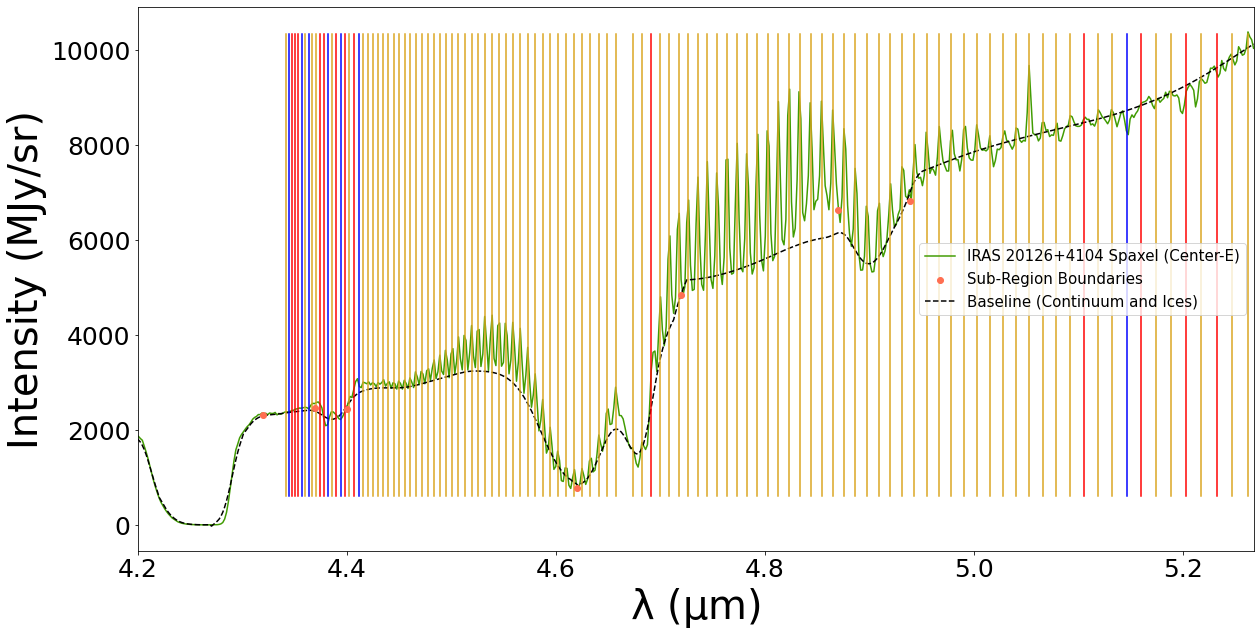

In [149]:
#read in some data
protostar_ind = 4 #CHANGE: to change protostars
hdul = fits.open(cube_file_list[protostar_ind])
jwst_cube = SpectralCube.read(hdul[1]) #accessing the cube for data  
cube = fits.getdata(cube_file_list[protostar_ind])

# define the wavelength grid (microns) from the header, always the same
wave = np.array(jwst_cube.spectral_axis.value, dtype=np.float64)[1:-1]
#fix the wavelengths to the correct wavelength axis for the protostar, they don't all have the same range of values
co_correct_inds = [i < np.max(wave) for i in co_v10_wavelengths] #notice we only compare to the max, no need to check for min
co_v10_wave_corrected = co_v10_wavelengths[co_correct_inds] 

#now that we have chosen a protostar...
#create list of coordinates and wavelength regimes to loop over; also labels for the different locations
source_coords = [(45,25),  (36,33), (27,34), (44,44), (47,49), (51,54), (60,63), (69,66), (76,52)]
source_labels = ['NE', 'Jet-E', 'SE', 'Center-E', 'Protostar', 'Center-W', 'H2-NW', 'Continuum-NW', 'Continuum-SW']
wave_cutoff_list = np.array([4.19, 4.32, 4.37, 4.4, 4.62, 4.72, 4.87, 4.939])
smooth_list = [1, 1, 10, 1, 5, 3, 15, 2, 10] #smoothing parameters for baseline #third to last originally 3
alpha_list = [1, 100, 50, 100, 3, 100, 0.1, 7, 1] #regularization parameter (relative levels of noise and signal)
# param_secondtolast = [2, 7]

#then set up a figure to loop over
fig, ax = plt.subplots(figsize=(20,10)) #setup fig, axes #make a figure to plot various locations on an image

#and loop over the axes and coordinates for a given object
for i in range(len(source_coords)):
    if i != 3:
        continue

    # extracting spectra
    # cont_sources = [(48,46), (32,30), (46, 47), (62, 67), (48, 46)] #centered on a location with fewer lines, better for smoothing directly
    # flux_1pix = cube[:, cont_sources[protostar_ind][0], cont_sources[protostar_ind][1]] 
    # source_coords = [(48,46), (44,44), (44, 41), (41, 45), (38, 42)] #centered on a location with more lines, better with knots...also for fewer artifacts
    flux_1pix = cube[:, int(source_coords[i][0]), int(source_coords[i][1]) ][1:-1] #for an example of a single pixel, but cut off the ends of the spectrum for better fitting results
    # flux_1pix = flux_1pix[wave_mask]
    ax.plot(wave, flux_1pix, color='xkcd:grassy green', label=protostar_names[protostar_ind] + ' Spaxel ' + '(' + source_labels[i] + ')') #plot observation here!

    #preset the top hat filter version
    baseline_fitter = Baseline(wave, check_finite=False)
    bkg_top = baseline_fitter.tophat(flux_1pix, half_window=3)[0]

    #formulating regimes to cutoff the spectrum and apply different smoothing factors
    cutoffs_flux_matched = bkg_top[[np.abs(wave - i).argmin() for i in wave_cutoff_list]]
    ax.scatter(wave_cutoff_list, cutoffs_flux_matched, color='xkcd:orange pink', zorder=100, label='Sub-Region Boundaries') #or can use oranges 

    #begin to loop through different parameters, defining a new baseline for a given section of the spectrum
    baseline_list = []

    #if edge case at start, do it by hand to omit conditionals
    # print('start', wave_cutoff_list[0])
    cutoff_mask = wave < wave_cutoff_list[0] #define mask up to first marker
    baseline_fitter = Baseline(wave[cutoff_mask], check_finite=False)     #compute baseline
    baseline = baseline_fitter.jbcd(bkg_top[cutoff_mask], half_window=smooth_list[0],alpha=alpha_list[0])[0]
    baseline_list = np.concatenate((baseline_list, baseline)) #concat to list

    #if between two values and not at the edge cases, we loop..
    cutoff_ind = 1 #to count loops
    while cutoff_ind <= len(wave_cutoff_list)-1:
        idx = (wave >= wave_cutoff_list[cutoff_ind-1]) & (wave <= wave_cutoff_list[cutoff_ind]) #logical masks joined with *
        cutoff_mask = np.where(idx)[0] #determine mask between two values
        # print('middle checks: ', cutoff_ind, wave_cutoff_list[cutoff_ind], len(flux_1pix[cutoff_mask]))

        #compute baseline
        baseline_fitter = Baseline(wave[cutoff_mask], check_finite=False)
        baseline = baseline_fitter.jbcd(bkg_top[cutoff_mask], half_window=smooth_list[cutoff_ind],alpha=alpha_list[cutoff_ind])[0]
        # baseline = baseline_fitter.asls(flux_1pix[cutoff_mask], lam=1e2, p=0.9)[0]
        baseline_list = np.concatenate((baseline_list, baseline)) #concat to list

        #update counter for loop, do after everything else
        cutoff_ind += 1

    #if edge case at end, do it by hand
    # print('end', wave_cutoff_list[-1]) #print to confirm cutoff at end
    cutoff_mask = wave > wave_cutoff_list[-1] #define mask past last marker
    baseline_fitter = Baseline(wave[cutoff_mask], check_finite=False)     #compute baseline
    # baseline = baseline_fitter.jbcd(bkg_top[cutoff_mask], half_window=smooth_list[cutoff_ind],alpha=alpha_list[cutoff_ind])[0]
    baseline = baseline_fitter.pspline_asls(bkg_top[cutoff_mask], lam=1e2, p=0.999, spline_degree=3)[0] #, half_window=smooth_list[-1],alpha=alpha_list[-1])[0]
    baseline_list = np.concatenate((baseline_list, baseline)) #concat to list

    #now trying to filter around our control or anchor points
    N_res = 100. * 1e-3 #knowing that average spectral resolution for the instrument is about 1/1000 microns, then applying multiples of that
    for cutoff_ind in range(len(wave_cutoff_list)):
        idx = ( wave >= (wave_cutoff_list[cutoff_ind]-N_res) ) & ( wave <= (wave_cutoff_list[cutoff_ind]+N_res) ) #logical masks joined with * using N_res
        idx_mask = np.where(idx)[0] #making mask
        baseline_list[idx_mask] = savgol_filter(baseline_list[idx_mask], polyorder=1, window_length=7) #in region around mask, apply filters

    #plotting 
    ax.plot(wave, baseline_list, 'k', label='Baseline (Continuum and Ices)', linestyle='--') #baseline
    # ax.plot(wave, flux_1pix-baseline_list, color='xkcd:twilight blue', label='Line Emission') #data

    #formulating a pseudo-continuum based on the baseline to determine ices and a transmission curve
    # baseline_fitter = Baseline(wave, check_finite=False)
    # ice_list = baseline_fitter.pspline_asls(baseline_list, lam=1e2, p=0.9999, spline_degree=2)[0]
    # ax.plot(wave, ice_list, linewidth=2, color='xkcd:shocking pink', linestyle=':', label='Polynomial Spline (Continuum)') # or can use xkcd:carnation pink
    # ax.plot(wave, baseline_list - ice_list, linewidth=2, color='xkcd:royal purple', linestyle='-.', label='Pseudo-ices')

    #now overplot all the CO lines to see if they align correctly (then we'll know if checking if local min or max will work!)
    for j in range(len(co_v10_wave_corrected)):
        co_wave_ind = np.argmin(np.abs(wave - co_v10_wave_corrected[j])) #locate a matching index for each line's wavelength
        #determine if in emission or absorption
        #need to check within +/- 2 spectral resolution elements
        if (flux_1pix[co_wave_ind] - flux_1pix[co_wave_ind+1] > 0 and flux_1pix[co_wave_ind] - flux_1pix[co_wave_ind-1] > 0) \
            or (flux_1pix[co_wave_ind] - flux_1pix[co_wave_ind+2] > 0 and flux_1pix[co_wave_ind] - flux_1pix[co_wave_ind-2] > 0): #in emission
            ax.axvline(co_v10_wave_corrected[j], 0.1, 0.95, color='goldenrod')
        elif (flux_1pix[co_wave_ind] - flux_1pix[co_wave_ind+1] < 0 and flux_1pix[co_wave_ind] - flux_1pix[co_wave_ind-1] < 0) \
            or (flux_1pix[co_wave_ind] - flux_1pix[co_wave_ind+2] < 0 and flux_1pix[co_wave_ind] - flux_1pix[co_wave_ind-2] < 0): #in absorption
            ax.axvline(co_v10_wave_corrected[j], 0.1, 0.95, color='blue')
        else: #else there's a third case, which is neither
            ax.axvline(co_v10_wave_corrected[j], 0.1, 0.95, color='red')

    #formatting plot
    # ax.axhline(0, color='k', linestyle=':') #a horizontal line at zero
    # ax.set_xticks(np.arange(3, 5.25, 0.25))
    ax.set_xlim(4.2, np.max(wave))
    ax.tick_params(axis='both', which='major', labelsize=25)
    ax.legend(loc='best', fontsize=15)
    ax.set_ylabel('Intensity (MJy/sr)', fontsize=40)
    ax.set_xlabel(r'$\rm \lambda \ (\mu m)$', fontsize=40)
    # fig.savefig('CentralSource_CO/' + cube_file_list[protostar_ind].split('/')[0]+'_FindBaseline.pdf')

Remake function for saving single fits images or maps

In [137]:
#a new fits file to be saved, maybe viewed in DS9
# may need to modify the function for a particular image, but generally useful
def fits_saver(array, wcs_header, name, save_path):
    '''
    array is a 2d array of data - could be from reprojecting one image onto another or from convolution...
    wcs_header is a header containing the wcs coords of the image that we projected onto or of the orig image (if from the convolution)
    name can be the path to some image you're using. It will get string split at the / character, and the func only takes the last element of that splitting
    save_path is the folder you want to save to...recommended to also add something to the start of the images names to make it clear what you did to them (e.g. 'Regridded/regrid_')
    '''
    
    #just setup an fits HDU from the data
    hdu_new = fits.PrimaryHDU(array, header=wcs_header)
    hdul = fits.HDUList([hdu_new])
    
        #saving the file
    #         name_fixfit = name[:-3] + 'fits'
#         new_filename = name_fixfit.split('/')[-1]  #grabs the file name we were using from before
#         hdul.writeto(save_path+new_filename, overwrite=True)
    hdul.writeto(save_path+name, overwrite=True)     
    return (save_path+name)

Then apply to entire cubes

In [144]:
#go through all files
for protostar_count, filepath in enumerate(cube_file_list):
    #open and read a data file
    protostar_id = filepath.split('/')[1] # for reference later when saving files
    hdul = fits.open(filepath)
    jwst_cube = SpectralCube.read(hdul[1]) #accessing the cube for data  
    jwst_cube_wave = np.array(jwst_cube.spectral_axis.value, dtype=np.float64)[1:-1] #cut ends off data
    jwst_data = np.array(np.nan_to_num(jwst_cube._data), dtype=np.float64)[1:-1]

    #fix the wavelengths to the correct wavelength axis for the protostar, they don't all have the same range of values
    co_correct_inds = [i < np.max(jwst_cube_wave) for i in co_v10_wavelengths] #notice we only compare to the max, no need to check for min
    co_v10_wave_corrected = co_v10_wavelengths[co_correct_inds] 
    co_v10_species_corrected = co_v10_species[co_correct_inds] 

    #set up arrays to be read in...
    # wave_offset_fit_arr = np.zeros((jwst_data.shape)) #assume square, initialize as zeros
    absorp_emiss_fit_arr = np.zeros((len(co_v10_wave_corrected), jwst_data.shape[1], jwst_data.shape[2])) #assume square, initialize as zeros

    #by explicit loops
    for i in range(jwst_data.shape[1]):
        for j in range(jwst_data.shape[2]):
            flux_1pix = jwst_data[:,i,j]

            #now overplot all the CO lines to see if they align correctly (then we'll know if checking if local min or max will work!)
            for k in range(len(co_v10_wave_corrected)):
                co_wave_ind = np.argmin(np.abs(jwst_cube_wave - co_v10_wave_corrected[k])) #locate a matching index for each line's wavelength
                #determine if in emission or absorption
                #need to check within +/- 2 spectral resolution elements
                if (flux_1pix[co_wave_ind] - flux_1pix[co_wave_ind+1] > 0 and flux_1pix[co_wave_ind] - flux_1pix[co_wave_ind-1] > 0) \
                    or (flux_1pix[co_wave_ind] - flux_1pix[co_wave_ind+2] > 0 and flux_1pix[co_wave_ind] - flux_1pix[co_wave_ind-2] > 0): #in emission
                    absorp_emiss_fit_arr[k,i,j] = 1 #positive
                elif (flux_1pix[co_wave_ind] - flux_1pix[co_wave_ind+1] < 0 and flux_1pix[co_wave_ind] - flux_1pix[co_wave_ind-1] < 0) \
                    or (flux_1pix[co_wave_ind] - flux_1pix[co_wave_ind+2] < 0 and flux_1pix[co_wave_ind] - flux_1pix[co_wave_ind-2] < 0): #in absorption
                    absorp_emiss_fit_arr[k,i,j] = -1 #negative
                # else: #else there's a third case, which is neither; in the cube version this case is default since we intialized the array with zeros
                #     absorp_emiss_fit_arr[k,i,j] = 0 #indeterminate

    #set folder, note this will always be the same...
    savepath = 'CO_Absorption_Emission_Maps/' 

    #saving baseline as cube
    # cube_unit_converted = np.multiply(cube_units, jwst_data)
    cube = SpectralCube(data=absorp_emiss_fit_arr, wcs=jwst_cube.wcs)
    cube_name = protostar_id + '_NIRspec_cube_CO_absorp_emiss.fits'
    cube.write(savepath+cube_name, format='fits', overwrite=True)
    print('Saved: ', savepath+cube_name)

    #ways to average baselines and also develope a header for relevant usage
    absorb_emiss_median = np.median(absorp_emiss_fit_arr, axis=0)
    absorb_emiss_mean = np.mean(absorp_emiss_fit_arr, axis=0)
    absorb_emiss_sum = np.sum(absorp_emiss_fit_arr, axis=0)
    absorb_emiss_header = jwst_cube.header #need to edit header a bit
    absorb_emiss_header['HISTORY'] = 'Found cube of relative minima (absorption) and maxima (emission), then took median of cube.'

    #saving summed cube...need to note in name...
    name = protostar_id + '_NIRspec_median_CO_absorp_emiss'+'.fits' #probably should edit this to id+linenameONLY+wavelength for future
    fits_path = fits_saver(absorb_emiss_median, absorb_emiss_header, name, savepath) #saving
    print('Saved: ', fits_path) #I use to confirm file has right path

    #saving summed cube...need to note in name...
    name = protostar_id + '_NIRspec_mean_CO_absorp_emiss'+'.fits' #probably should edit this to id+linenameONLY+wavelength for future
    fits_path = fits_saver(absorb_emiss_mean, absorb_emiss_header, name, savepath) #saving
    print('Saved: ', fits_path) #I use to confirm file has right path

    #saving summed cube...need to note in name...
    name = protostar_id + '_NIRspec_sum_CO_absorp_emiss'+'.fits' #probably should edit this to id+linenameONLY+wavelength for future
    fits_path = fits_saver(absorb_emiss_sum, absorb_emiss_header, name, savepath) #saving
    print('Saved: ', fits_path) #I use to confirm file has right path

    #rewrite the line list to match the indices as displayed in each cube
    #otherwise cannot interpret
    line_wave_filename = '_co_v10_line_wavelength_list.txt'
    name = protostar_id + line_wave_filename
    with open(savepath + name, 'w') as f:
        f.write('Line Number, Wavelength (um), CO v=1-0 Species \n') #write column header
        for count, (wavelength, line_name) in enumerate(zip(co_v10_wave_corrected, co_v10_species_corrected)):
                f.write(str(count) + ',' + str(wavelength) + ',' + line_name + '\n') #write wavelengths


Saved:  CO_Absorption_Emission_Maps/IRAS16253_NIRspec_cube_CO_absorp_emiss.fits
Saved:  CO_Absorption_Emission_Maps/IRAS16253_NIRspec_median_CO_absorp_emiss.fits
Saved:  CO_Absorption_Emission_Maps/IRAS16253_NIRspec_mean_CO_absorp_emiss.fits
Saved:  CO_Absorption_Emission_Maps/IRAS16253_NIRspec_sum_CO_absorp_emiss.fits
Saved:  CO_Absorption_Emission_Maps/B335_NIRspec_cube_CO_absorp_emiss.fits
Saved:  CO_Absorption_Emission_Maps/B335_NIRspec_median_CO_absorp_emiss.fits
Saved:  CO_Absorption_Emission_Maps/B335_NIRspec_mean_CO_absorp_emiss.fits
Saved:  CO_Absorption_Emission_Maps/B335_NIRspec_sum_CO_absorp_emiss.fits
Saved:  CO_Absorption_Emission_Maps/HOPS153_NIRspec_cube_CO_absorp_emiss.fits
Saved:  CO_Absorption_Emission_Maps/HOPS153_NIRspec_median_CO_absorp_emiss.fits
Saved:  CO_Absorption_Emission_Maps/HOPS153_NIRspec_mean_CO_absorp_emiss.fits
Saved:  CO_Absorption_Emission_Maps/HOPS153_NIRspec_sum_CO_absorp_emiss.fits
Saved:  CO_Absorption_Emission_Maps/HOPS370_NIRspec_cube_CO_absor